In [23]:
# Core libraries
from PIL import Image, ImageDraw, ImageFont
import imageio.v2 as imageio  # avoids deprecation warnings
import os
from IPython.display import Video, display

# Global settings
w, h = 200, 200  # width & height for images

# Try a larger, readable font; fall back to default if not found
try:
    # DejaVuSans is bundled with many environments (including Colab/Jupyter)
    font = ImageFont.truetype("DejaVuSans.ttf", size=48)
except Exception:
    font = ImageFont.load_default()



In [24]:
from pathlib import Path
import zipfile

# Path to ZIP file and extract folder
zip_path = Path("/content/drive/MyDrive/asl_alphabet_test.zip")
extract_dir = zip_path.with_suffix("")  # same name but no .zip extension

# Unzip if not already extracted
if not extract_dir.exists():
    print(f"📦 Extracting {zip_path} to {extract_dir} ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("📂 Dataset already extracted.")

# Update dataset_path to the extracted folder
dataset_path = extract_dir

def get_letter_image(ch):
    """
    Load an ASL image for the given letter from dataset.
    If not available, fallback to drawing letter on white background.
    """
    ch = ch.upper()
    path = dataset_path / f"{ch}.png"

    if path.exists():
        return Image.open(path).resize((w, h))
    else:
        # fallback: draw letter on white background
        img = Image.new("RGB", (w, h), "white")
        draw = ImageDraw.Draw(img)

        # Center text in the image
        if hasattr(draw, "textbbox"):
            bbox = draw.textbbox((0, 0), ch, font=font)
            tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
        else:
            tw, th = draw.textsize(ch, font=font)

        draw.text(((w - tw) // 2, (h - th) // 2), ch, fill="black", font=font)
        return img


📦 Extracting /content/drive/MyDrive/asl_alphabet_test.zip to /content/drive/MyDrive/asl_alphabet_test ...
✅ Extraction complete.


In [25]:
import numpy as np
from pathlib import Path

def text_to_asl_video_dataset(text, out="/tmp/asl_fingerspell.mp4", fps=1):
    """
    Converts a string to ASL video using dataset images.
    Saves video to `out` and displays inline in Jupyter.
    Tries MP4 (H.264) first; falls back to GIF if ffmpeg is unavailable.
    """
    # Build frames once; include a short blank for spaces
    frames_pil = []
    for ch in text:
        if ch == " ":
            # pause frame for a space
            frames_pil.append(Image.new("RGB", (w, h), "white"))
        else:
            frames_pil.append(get_letter_image(ch))

    # Filter out Nones (just in case) and convert to numpy arrays
    frames = [np.array(frm.convert("RGB")) for frm in frames_pil if frm is not None]

    if not frames:
        print("❌ No frames available to generate video.")
        return None

    out = str(out)
    Path(out).parent.mkdir(parents=True, exist_ok=True)

    # Try MP4 first
    wrote = False
    if out.lower().endswith(".mp4"):
        try:
            # requires: pip install imageio-ffmpeg
            imageio.mimwrite(out, frames, fps=fps, codec="libx264", quality=8)
            wrote = True
        except Exception as e:
            print(f"⚠️ MP4 write failed ({e}). Falling back to GIF.")

    # Fallback to GIF if MP4 failed or extension isn't .mp4
    if not wrote:
        if not out.lower().endswith(".gif"):
            out = Path(out).with_suffix(".gif")
            out = str(out)
        # loop=0 = infinite loop
        imageio.mimsave(out, frames, fps=fps, loop=0)

    print(f"✅ Video ready: {out}")
    display(Video(out, embed=True))
    return out


In [26]:
video_path = text_to_asl_video_dataset("HELLO WORLD", fps=1)


✅ Video ready: /tmp/asl_fingerspell.mp4


In [15]:
video_path = text_to_asl_video_dataset("HELLO WORLD", fps=2)  # 2 letters per second


✅ Video ready: /tmp/asl_fingerspell.mp4


In [27]:
from pathlib import Path
import zipfile
import re
from PIL import Image, ImageDraw

# ---------- unzip (once) ----------
zip_path = Path("/content/drive/MyDrive/asl_alphabet_test.zip")
extract_dir = zip_path.with_suffix("")  # /content/drive/MyDrive/asl_alphabet_test

if not extract_dir.exists():
    print(f"📦 Extracting {zip_path} to {extract_dir} ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print(f"📂 Dataset already extracted at: {extract_dir}")

dataset_root = extract_dir

# ---------- build an index: letter -> example image path ----------
VALID_EXTS = {".png", ".jpg", ".jpeg"}
LETTERS = [chr(c) for c in range(ord("A"), ord("Z")+1)]

def build_dataset_index(root: Path):
    """
    Recursively search for images that correspond to A..Z.
    Strategy:
      1) If a parent folder name is exactly the letter, use any image inside it.
      2) Else, if a filename starts with the letter (e.g., A_123.jpg), use it.
    Returns dict: { 'A': Path(...), 'B': Path(...), ... }
    """
    index = {}

    # Pass 1: by parent folder name
    for p in root.rglob("*"):
        if p.is_dir() and p.name.upper() in LETTERS:
            letter = p.name.upper()
            # pick first image in that folder
            for img in p.rglob("*"):
                if img.is_file() and img.suffix.lower() in VALID_EXTS:
                    index.setdefault(letter, img)
                    break

    # Pass 2: by filename pattern if still missing
    for img in root.rglob("*"):
        if img.is_file() and img.suffix.lower() in VALID_EXTS:
            name_up = img.stem.upper()
            # match names like "A.png", "A_001.jpg", "a (2).jpeg"
            m = re.match(r"^([A-Z])(\b|_|-|\.|\s|\(|$)", name_up)
            if m:
                letter = m.group(1)
                index.setdefault(letter, img)

    return index

DATA_INDEX = build_dataset_index(dataset_root)

# Report coverage
missing = [L for L in LETTERS if L not in DATA_INDEX]
print(f"🧩 Indexed letters: {sorted(DATA_INDEX.keys())}")
if missing:
    print(f"⚠️ Missing letters in dataset: {missing}")

# ---------- image retrieval using the index ----------
def get_letter_image(ch):
    """
    Return PIL.Image for the letter. Uses dataset index if available,
    otherwise falls back to a generated white tile with centered text.
    """
    ch = ch.upper()
    path = DATA_INDEX.get(ch)

    if path and path.exists():
        try:
            return Image.open(path).convert("RGB").resize((w, h))
        except Exception as e:
            print(f"⚠️ Failed to open {path}: {e}")

    # fallback: draw letter tile
    img = Image.new("RGB", (w, h), "white")
    draw = ImageDraw.Draw(img)
    if hasattr(draw, "textbbox"):
        bbox = draw.textbbox((0, 0), ch, font=font)
        tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    else:
        tw, th = draw.textsize(ch, font=font)
    draw.text(((w - tw) // 2, (h - th) // 2), ch, fill="black", font=font)
    return img


📂 Dataset already extracted at: /content/drive/MyDrive/asl_alphabet_test
🧩 Indexed letters: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


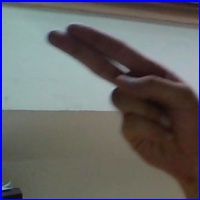

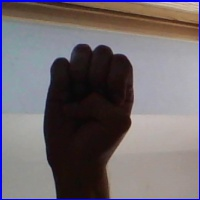

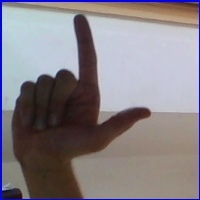

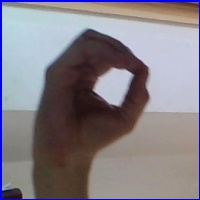

In [28]:
display(get_letter_image("H"))
display(get_letter_image("E"))
display(get_letter_image("L"))
display(get_letter_image("O"))


In [29]:
# If you haven't already, ensure numpy + codecs are available:
# !pip install -q imageio imageio-ffmpeg pillow

video_path = text_to_asl_video_dataset("HELLO WORLD", fps=2)
display(Video(video_path, embed=True))


✅ Video ready: /tmp/asl_fingerspell.mp4
